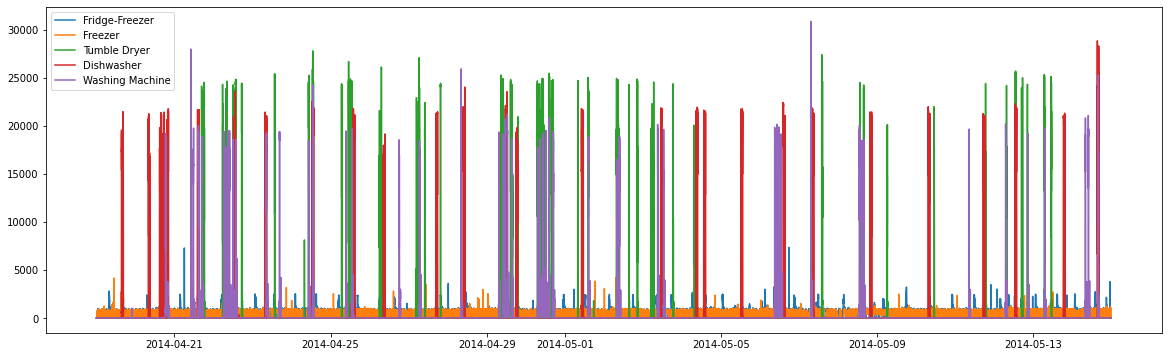

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stumpy
from stumpy import core
from stumpy.mmotifs import mmotifs

plt.style.use(
    "https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle"
)

start_date, end_date = "2014-04-19", "2014-05-15"
df = pd.read_csv("../CLEAN_House3.csv")
df["Time"] = pd.to_datetime(df["Time"])
colnames = {
    "Appliance1": "Toaster",
    "Appliance2": "Fridge-Freezer",
    "Appliance3": "Freezer",
    "Appliance4": "Tumble Dryer",
    "Appliance5": "Dishwasher",
    "Appliance6": "Washing Machine",
    "Appliance7": "Television",
    "Appliance8": "Microwave",
    "Appliance9": "Kettle",
}
df = (
    df.rename(colnames, axis="columns")
    .loc[
        :,
        [
            "Time",
            "Fridge-Freezer",
            "Freezer",
            "Tumble Dryer",
            "Dishwasher",
            "Washing Machine",
        ],
    ]
    .query("Time >= @start_date and Time <= @end_date")
    .groupby(pd.Grouper(key="Time", freq="T"))
    .sum()
)

for colname in df.columns:
    plt.plot(df[colname], label=colname)
    plt.legend()

Eliminate constant regions

In [2]:
# m was set to 4 hours
m = 4 * 60

padded_stddev = np.zeros(len(df))
for colname in df.columns:
    stddev = core.rolling_nanstd(df.loc[:, colname].values, m)
    padded_stddev[-len(stddev):] = stddev
    modified_values = df.loc[:, colname].where(padded_stddev != 0.0, np.nan)
    df = df.assign(**{colname: modified_values})
    # Apply noise to 0 regions
    noise = np.random.uniform(0.0, 0.1, size=len(df))
    zero_idx = df.loc[:, colname].where(df.loc[:, colname] != 0, noise)
    df = df.assign(**{colname: zero_idx})

Compute the mutli-dimensional matrix profile

Notice: Each row of the array corresponds to each MP for a given dimension --> first row: 1D MP, second: 2D MP

In [3]:
mps, indices = stumpy.mstump(df.astype(float), m)

Find the multidimensional motif pair

In [4]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices, max_distance=np.inf, max_matches=2
)

Visualize the motif pair

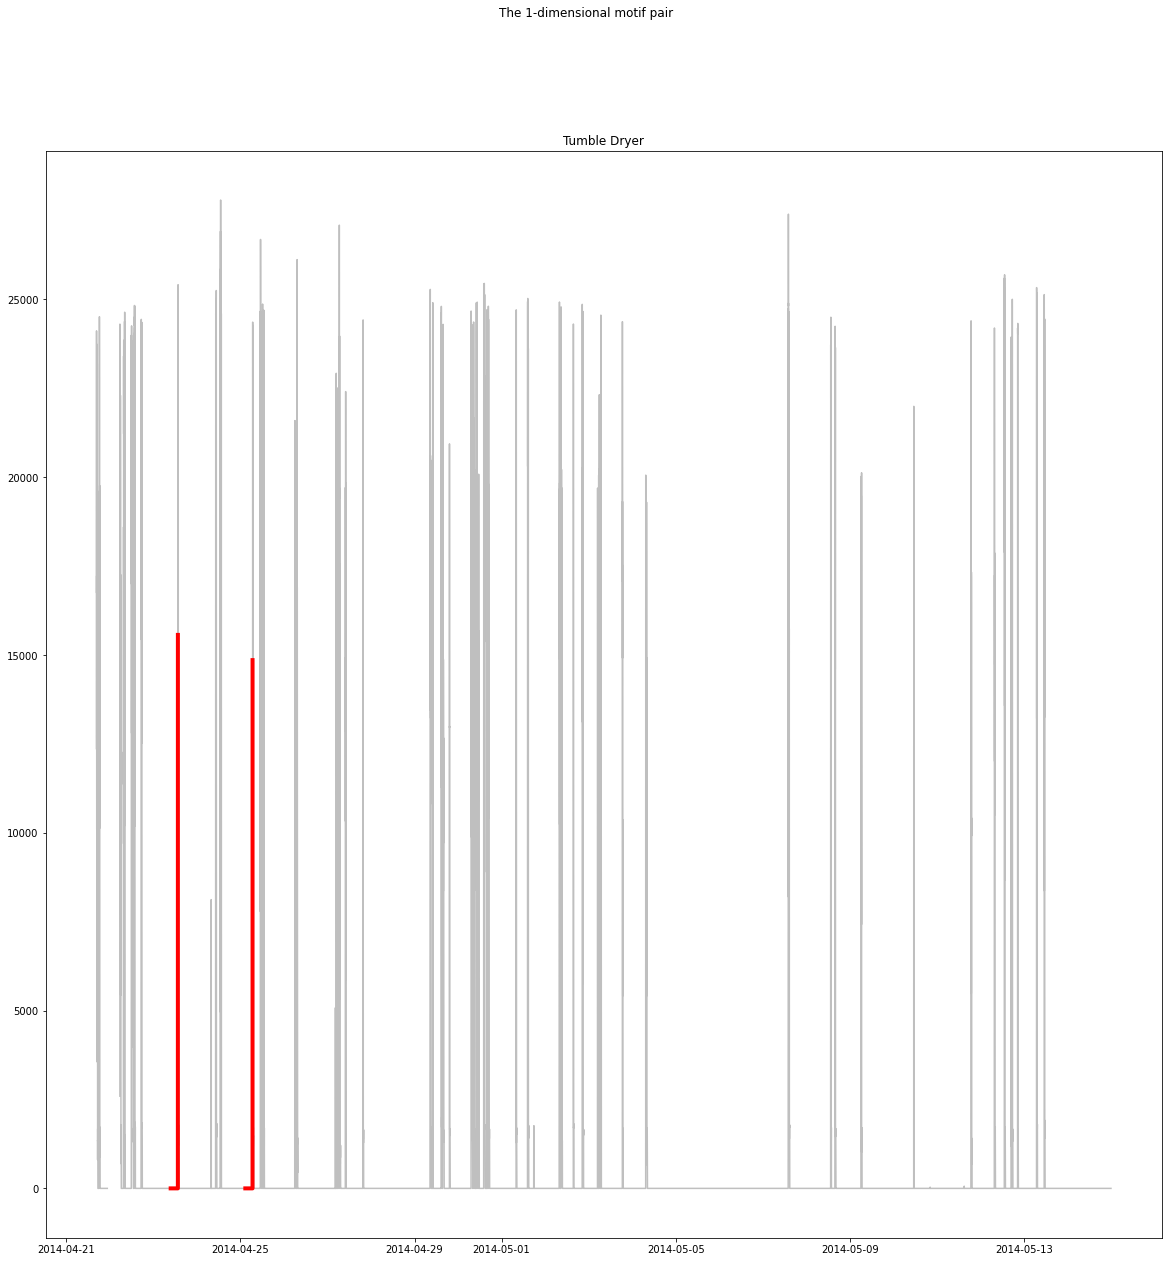

In [5]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    motif_indices = motifs_indices[motif_num]
    mdl = motifs_mdls[motif_num]
    S = motifs_subspaces[motif_num]
    subspace = [df.columns.values[s] for s in S]

    k = len(S)
    f, axs = plt.subplots(k, 1, figsize=(20, 20), sharex=True)
    plt.suptitle(f"The {k}-dimensional motif pair")

    for j, s in enumerate(S):
        time_series = df[df.columns[s]]
        if k > 1:
            ax = axs[j]
        else:
            ax = axs
        ax.plot(time_series, c="0.75")
        ax.set_title(df.columns.values[s])

        motif_idx = motif_indices[0]
        nn_idx = motif_indices[1]
        ax.plot(time_series[motif_idx : motif_idx + m], c="r", linewidth=4)
        ax.plot(time_series[nn_idx : nn_idx + m], c="r", linewidth=4)
        # ax.axvline(x=motif_idx, linestyle='dashed', c='k', linewidth=2)
        # ax.axvline(x=nn_idx, linestyle='dashed', c='k', linewidth=2)

        # Only relevant if you want to find further matches
        # Set motif_indices[2:] to avoid double counting the motif pair
        [ax.plot(time_series[match : match + m]) for match in motif_indices[2:]]

Plot MDL ...